In [25]:
import pickle, gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM, SVC
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import Image

path_pattern = './output/persistence/{}'
X_train = pickle.load(gzip.open(path_pattern.format('X_train.gz'), 'r'))
X_test = pickle.load(gzip.open(path_pattern.format('X_test.gz'), 'r'))
y_train = pickle.load(gzip.open(path_pattern.format('y_train.gz'), 'r'))
y_test = pickle.load(gzip.open(path_pattern.format('y_test.gz'), 'r'))

In [26]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

perform_tuning = False

if perform_tuning:
    
    param_grid = {'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9], # how many outliers we allow
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf', 'linear'] } # how far the influence of a single training example reaches

    grid = GridSearchCV(SVC(), param_grid, refit=True, scoring='roc_auc', verbose=1) # (roc_aus considers both recall & precision and find balance)
    grid.fit(X_train, y_train)

    print('Grid Best Params:\n', grid.best_params_)
    print('Grid Best Estimator:\n', grid.best_estimator_)

# -- Output --
# Fitting 5 folds for each of 70 candidates, totalling 350 fits
# Grid Best Params:
#  {'C': 0.7, 'gamma': 1, 'kernel': 'rbf'}
# Grid Best Estimator:
#  SVC(C=0.7, gamma=1)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       881
           1       0.86      0.78      0.82       406

    accuracy                           0.89      1287
   macro avg       0.88      0.86      0.87      1287
weighted avg       0.89      0.89      0.89      1287



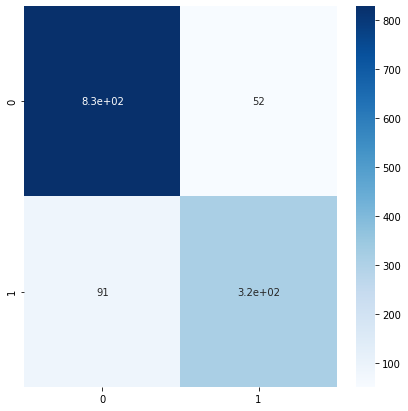

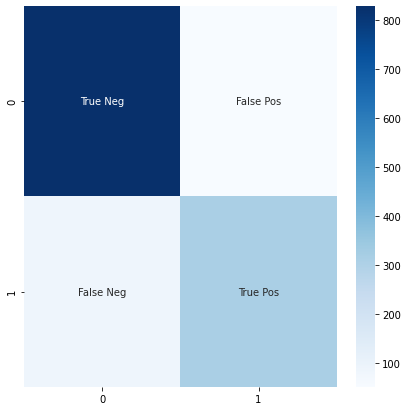

In [27]:

# Train the tuned model
clf = SVC(kernel='rbf', gamma=1, C=0.7).fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
y_pred = np.array([(0 if p < 0 else p) for p in y_pred])

cm = confusion_matrix(y_test, y_pred)
print('Classification Report:\n', classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7, 7))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.show()

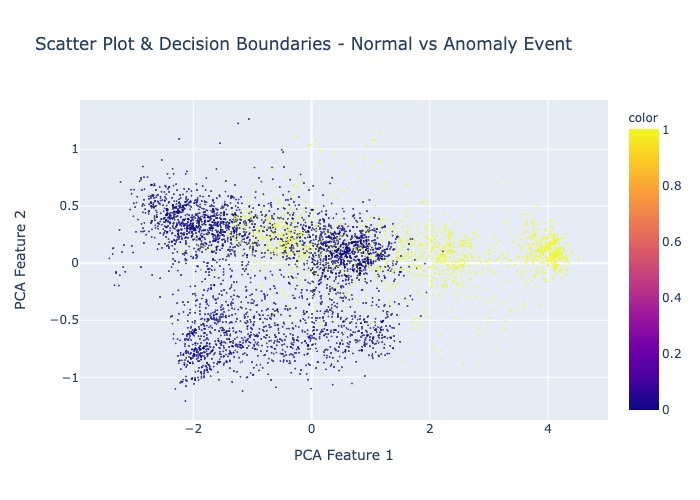

In [28]:

# Visualise the RBF SVM 
from sklearn.decomposition import PCA
import plotly.express as px  
import plotly.graph_objects as go
import plotly.graph_objects as graph_objects

# Reduce dimensionality to 2 features with PCA to visualise in 2D space
pca_2d = PCA(n_components=2).fit_transform(X_train)

# Train the model
clf_v = SVC(kernel='rbf', gamma=1, C=1, probability=True).fit(pca_2d, y_train)

# Scatter plot for training data
fig = px.scatter(x=pca_2d[:, 0], y=pca_2d[:, 1], color=y_train, opacity=.7, labels={'x': 'PCA Feature 1', 'y': 'PCA Feature 2'}, title='Scatter Plot & Decision Boundaries - Normal vs Anomaly Event')
fig.update_traces(marker=dict(size=2))

fig.write_image('./output/image/scatter_2d_1.jpg')
Image('./output/image/scatter_2d_1.jpg')

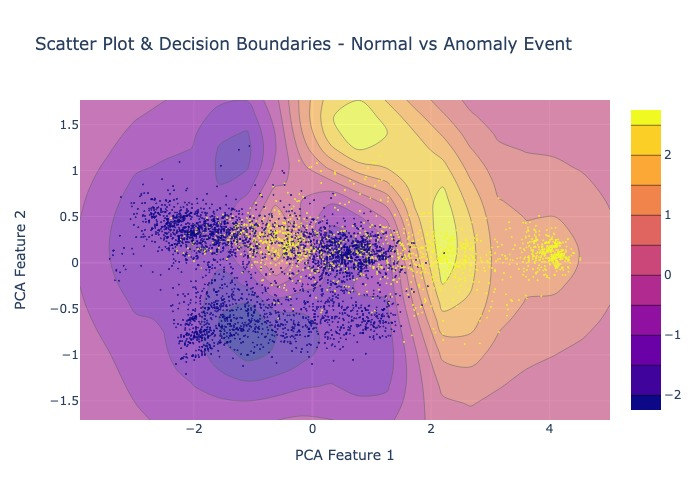

In [29]:

# Find the scale of x and y axes (ie. pca 2d features)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Generate data points in between the scales given
xx = np.linspace(pca_2d[:, 0].min() - .5, pca_2d[:, 0].max() + .5, 20)
yy = np.linspace(pca_2d[:, 1].min() - .5, pca_2d[:, 1].max() + .5, 20)

# Prepare to find all the combinations between two
XX, YY = np.meshgrid(xx, yy)

# Ravel makes nd array become 1d array, and vstack finds all the pairs between given two arrays
xy = np.vstack([XX.ravel(), YY.ravel()]).T
z_y_pred = clf_v.decision_function(xy).reshape(XX.shape)

# Visualise predicted contours to draw decision boundaries
fig.add_traces(go.Contour(x=xx, y=yy, z=z_y_pred, opacity=.6))
fig.update(layout_coloraxis_showscale=False)

fig.write_image('./output/image/scatter_2d_2.jpg')
Image('./output/image/scatter_2d_2.jpg')

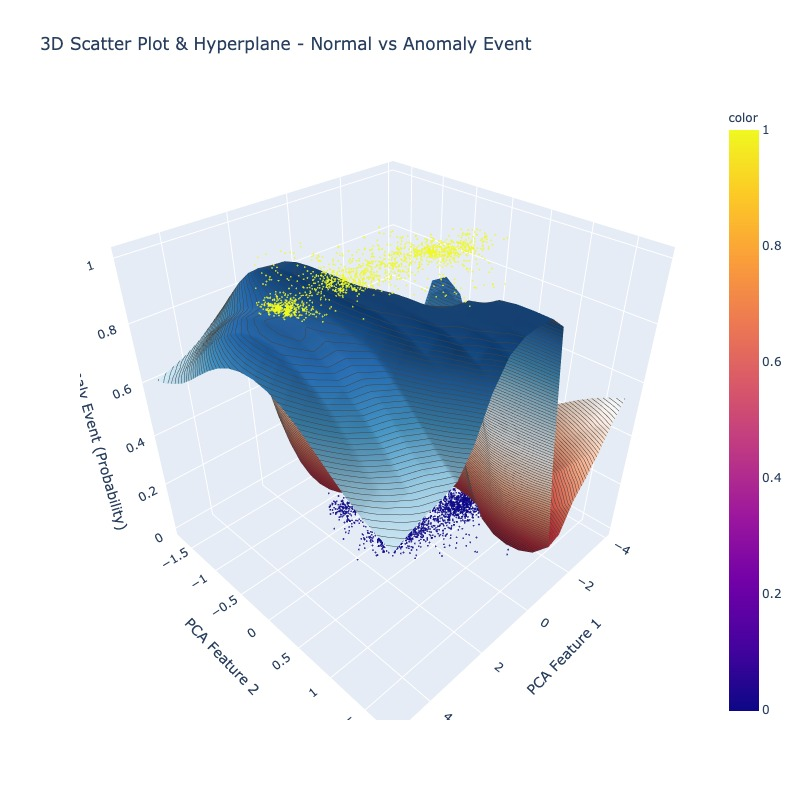

In [30]:
# Visualise in 3D plot with a hyperplane
y_pred = clf_v.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:, 1]
z_y_pred = y_pred.reshape(XX.shape)

fig = px.scatter_3d(x=pca_2d[:, 0], y=pca_2d[:, 1], z=y_train, color=y_train, opacity=.8, labels={'x': 'PCA Feature 1', 'y': 'PCA Feature 2', 'z': 'Anomaly Event (Probability)'}, title='3D Scatter Plot & Hyperplane - Normal vs Anomaly Event')
fig.update_traces(marker=dict(size=1))

fig.add_traces(go.Surface(x=xx, y=yy, z=z_y_pred, name='SVM Prediction',
                              colorscale='RdBu', showscale=False, 
                              contours = {"z": {"show": True, "start": -10, "end": 10, "size": 0.01}}))

fig.update_layout(width=800, height=800)

fig.write_image('./output/image/scatter_3d_1.jpg')
Image('./output/image/scatter_3d_1.jpg')
# fig.show()
